1. Importing Libraries


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
import cv2
from os import listdir
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import VGG16, VGG19, ResNet50, DenseNet121
from tensorflow.keras.optimizers import Adam


2. Defining Necessary Functions

In [9]:
# Function to convert images to arrays
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None:
            image = cv2.resize(image, (256, 256))
            return img_to_array(image)
        else:
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

# Function to load dataset from a directory (train or test)
def load_dataset(data_dir):
    image_list, label_list = [], []
    for directory in listdir(data_dir):
        plant_image_list = listdir(f"{data_dir}/{directory}")
        for files in plant_image_list:
            image_path = f"{data_dir}/{directory}/{files}"
            image_list.append(convert_image_to_array(image_path))
            label_list.append(binary_labels[all_labels.index(directory)])
    return image_list, label_list

# Function to plot the test images
def output_plot(image, model):
    class_labels = classes
    fig, axs = plt.subplots(1, 2, figsize=(10, 2))

    predictions = model.predict(image.reshape(1, 256, 256, 3))

    axs[0].imshow(array_to_img(image))
    axs[0].axis('off')
    prediction_values = predictions[0]

    max_index = np.argmax(prediction_values)
    colors = ['green' if i == max_index else 'blue' for i in range(len(class_labels))]

    axs[1].barh(class_labels, prediction_values, color=colors)
    axs[1].set_xlim([0, 1])

    plt.tight_layout()
    plt.show()



3. Loading the Data

In [10]:
dir_path = r"C:\Users\ADMIN\Documents\Document\USTH\B3\Luan_tot_nghiep\dataset\mango leaf dataset"

all_labels = [i.split('/')[-1] for i in os.listdir(dir_path)]
binary_labels = [int(i) for i in range(len(all_labels))]

images, labels = load_dataset(dir_path)

In [11]:
import os
import cv2
import numpy as np

# Khai báo đường dẫn gốc
data_path = r"C:\Users\ADMIN\Documents\Document\USTH\B3\Luan_tot_nghiep\dataset\mango leaf dataset"
all_labels = os.listdir(data_path)
image_size = (256, 256)

x_train = []
y_train = []

for label_index, label_name in enumerate(all_labels):
    label_folder = os.path.join(data_path, label_name)
    for image_name in os.listdir(label_folder):
        image_path = os.path.join(label_folder, image_name)

        img = cv2.imread(image_path)
        if img is None:
            print(f"❌ Không đọc được ảnh: {image_path}")
            continue  # Bỏ qua ảnh lỗi

        img = cv2.resize(img, image_size)           # Resize ảnh về đúng kích thước
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Đổi từ BGR sang RGB
        img = img / 255.0                           # Chuẩn hóa về [0,1]

        x_train.append(img)
        y_train.append(label_index)

x_train = np.array(x_train, dtype=np.float32)
y_train = np.array(y_train)

# One-hot encode label
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes=len(all_labels))

print("✅ Done loading images")
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)


✅ Done loading images
x_train shape: (4000, 256, 256, 3)
y_train shape: (4000, 8)


In [12]:
all_labels

['Anthracnose',
 'Bacterial Canker',
 'Cutting Weevil',
 'Die Back',
 'Gall Midge',
 'Healthy',
 'Powdery Mildew',
 'Sooty Mould']

In [13]:
from sklearn.model_selection import train_test_split

train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.05, random_state=42  # 20% for testing
)

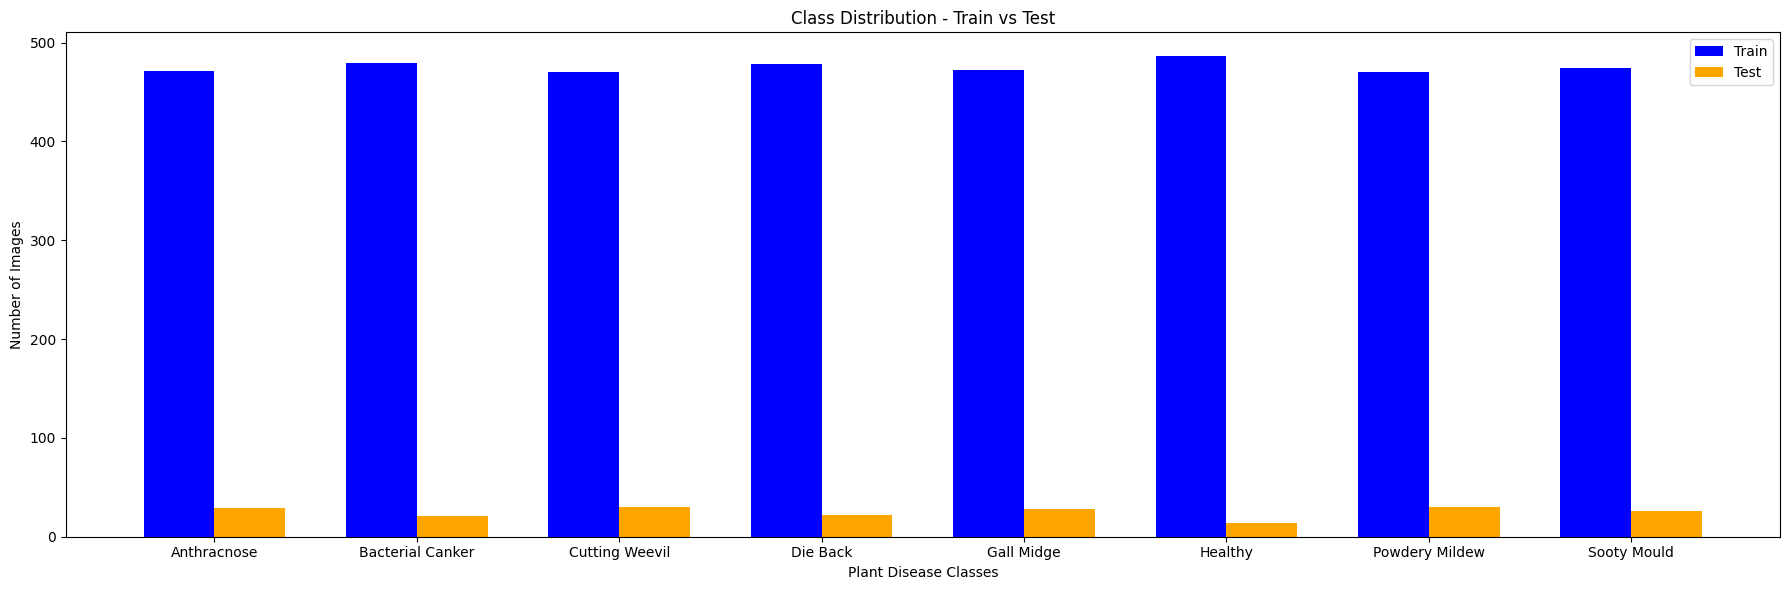

In [14]:
train_class_counts = np.bincount(train_labels)
test_class_counts = np.bincount(test_labels, minlength=3)

classes = all_labels
train_colors = 'blue'
test_colors = 'orange'
bar_width = 0.35
index = np.arange(len(classes))
plt.figure(figsize=(18, 6))
plt.bar(index, train_class_counts, width=bar_width, color=train_colors, label='Train')
plt.bar(index + bar_width, test_class_counts, width=bar_width, color=test_colors, label='Test')
plt.xlabel("Plant Disease Classes")
plt.ylabel("Number of Images")
plt.title("Class Distribution - Train vs Test")
plt.xticks(index + bar_width / 2, classes)
plt.legend()
plt.tight_layout()
plt.show()

4. Pre-processing Data

In [15]:
# Normalize image data (convert pixel values to range 0-1)
x_train = np.array(train_images, dtype=np.float16) / 255.0
x_test = np.array(test_images, dtype=np.float16) / 255.0

# Convert labels to categorical (one-hot encoding)
y_train = to_categorical(np.array(train_labels), num_classes=len(classes))
y_test = to_categorical(np.array(test_labels), num_classes=len(classes))

print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


x_train shape: (3800, 256, 256, 3)
x_test shape: (200, 256, 256, 3)
y_train shape: (3800, 8)
y_test shape: (200, 8)


5. Visualization

5.1. Sample Train Images

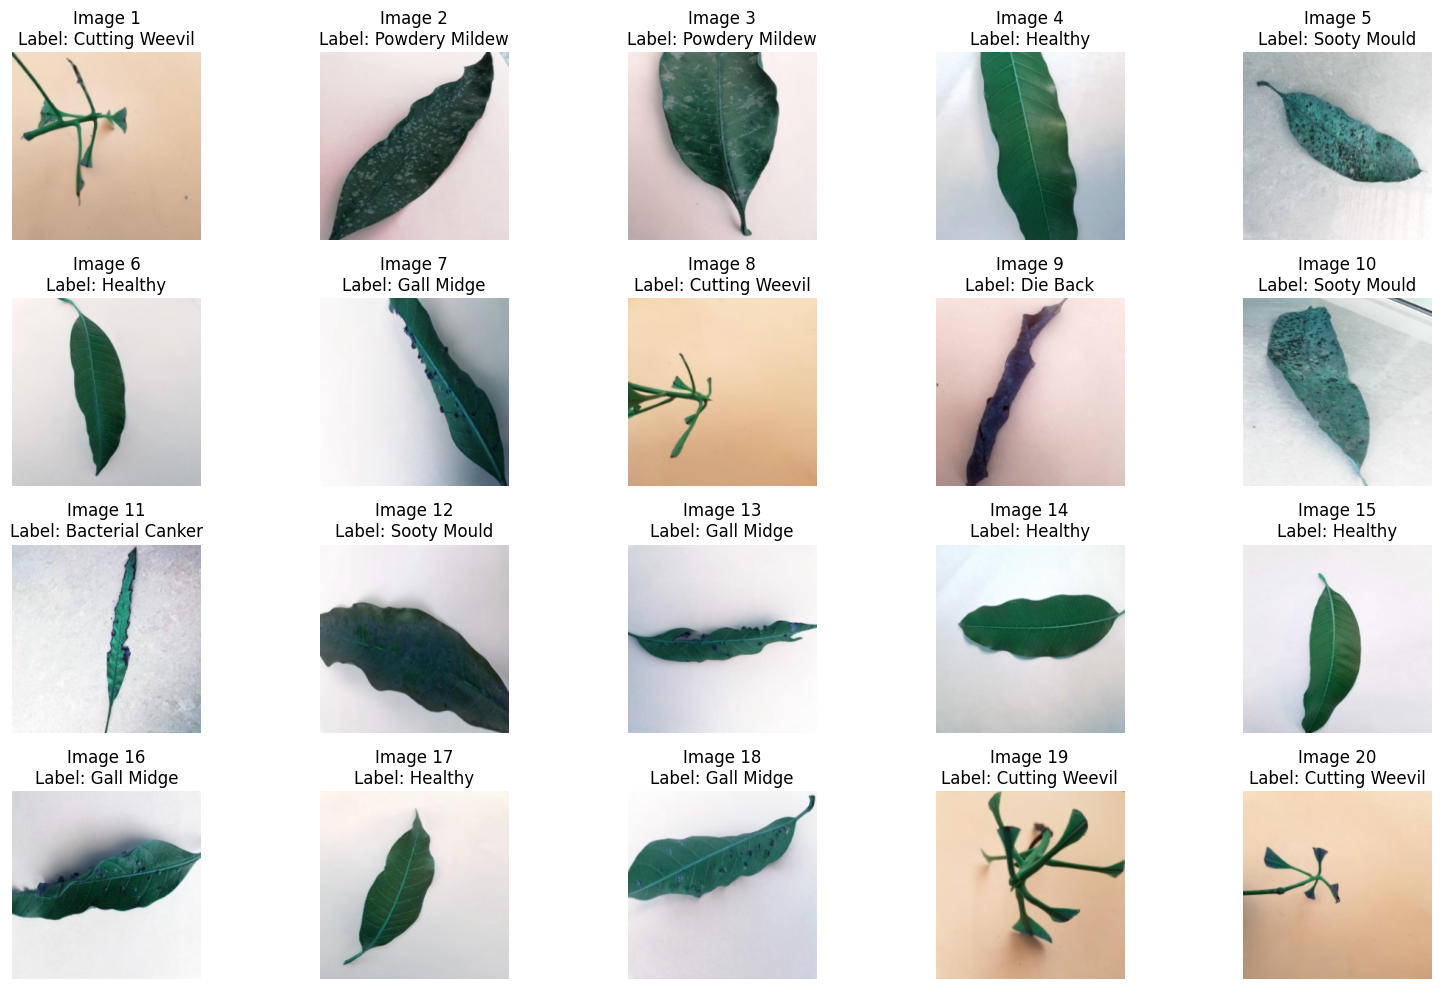

In [16]:
plt.figure(figsize=(16, 10))
sample_indices = random.sample(range(len(x_train)), 20)

for i, idx in enumerate(sample_indices):
    plt.subplot(4, 5, i + 1)
    plt.imshow(array_to_img(x_train[idx]))
    label = np.argmax(y_train[idx])
    plt.title(f"Image {i + 1}\nLabel: {all_labels[label]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

5.2 Sample Test Images

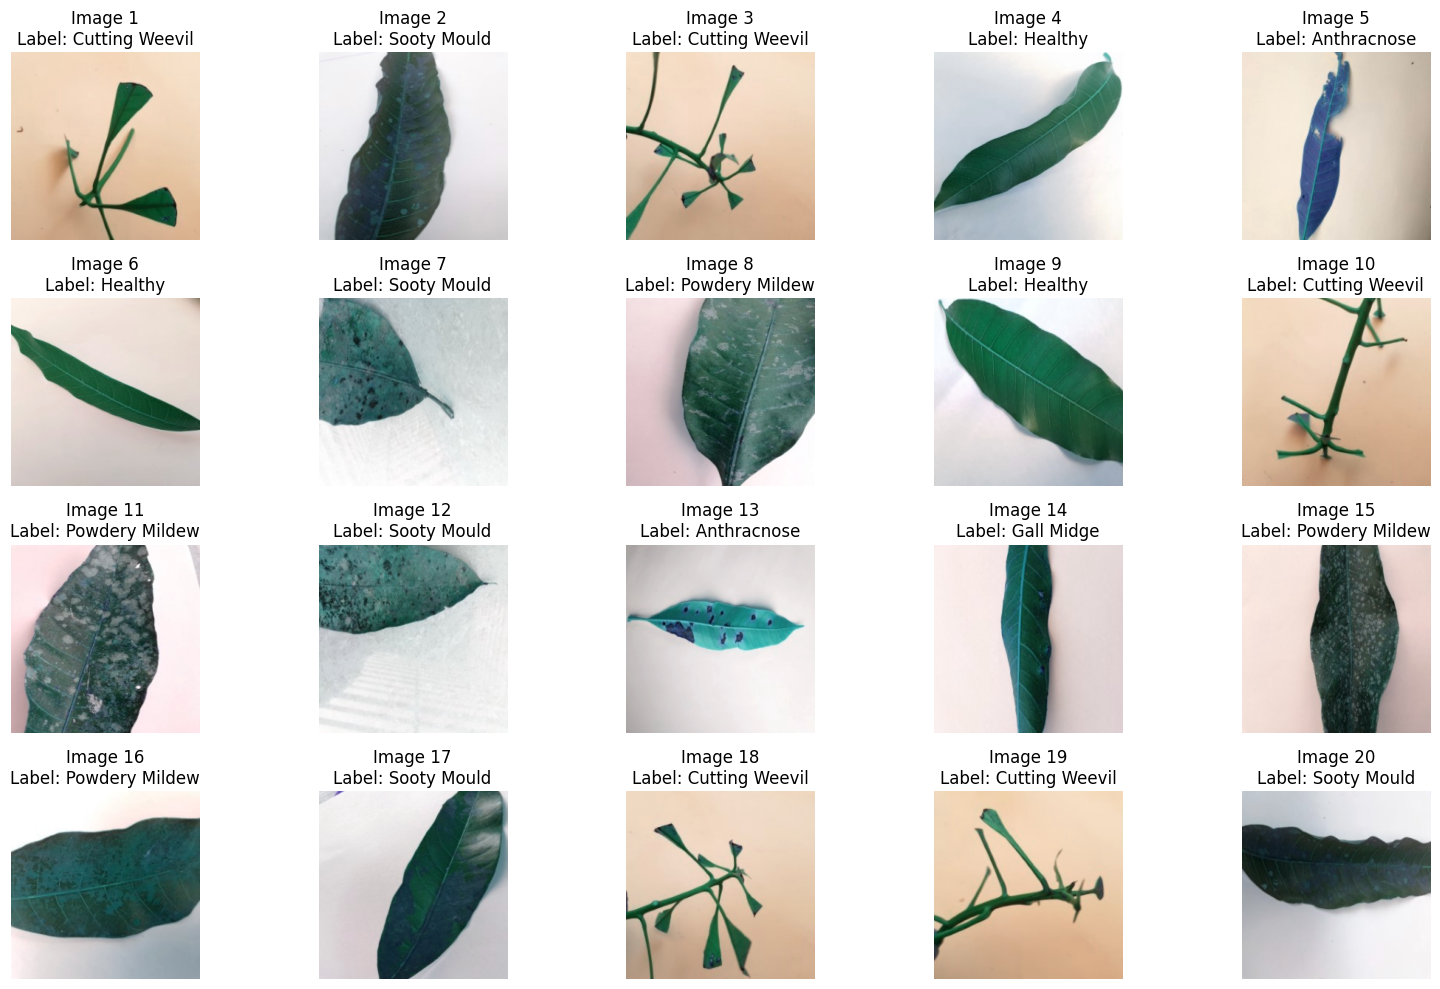

In [17]:
plt.figure(figsize=(16, 10))
sample_indices = random.sample(range(len(x_test)), 20)

for i, idx in enumerate(sample_indices):
    plt.subplot(4, 5, i + 1)
    plt.imshow(array_to_img(x_test[idx]))
    label = np.argmax(y_test[idx])
    plt.title(f"Image {i + 1}\nLabel: {all_labels[label]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

6. Model Definition

In [18]:
from tensorflow.keras.regularizers import l2

# Function to build models using popular CNN architectures
def build_model(model_name):
    if model_name == 'VGG16':
        base_model = VGG16(include_top=False, input_shape=(256, 256, 3))
    elif model_name == 'VGG19':
        base_model = VGG19(include_top=False, input_shape=(256, 256, 3))
    elif model_name == 'ResNet50':
        base_model = ResNet50(include_top=False, input_shape=(256, 256, 3))
    elif model_name == 'DenseNet121':
        base_model = DenseNet121(include_top=False, input_shape=(256, 256, 3))
    else:
        base_model = Sequential([
            Conv2D(96, (11, 11), strides=4, activation='relu', input_shape=(256, 256, 3)),
            MaxPooling2D(pool_size=(3, 3), strides=2),
            Conv2D(256, (5, 5), padding="same", activation='relu'),
            MaxPooling2D(pool_size=(3, 3), strides=2),
            Conv2D(384, (3, 3), padding="same", activation='relu'),
            Conv2D(384, (3, 3), padding="same", activation='relu'),
            Conv2D(256, (3, 3), padding="same", activation='relu'),
            MaxPooling2D(pool_size=(3, 3), strides=2),
            Flatten(),
            Dense(4096, activation='relu', kernel_regularizer=l2(0.01)),
            Dropout(0.6),
            Dense(4096, activation='relu', kernel_regularizer=l2(0.01)),
            Dropout(0.6),
            Dense(len(classes), activation='softmax')
        ])
        return base_model

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(1024, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.6),
        Dense(len(classes), activation='softmax')
    ])

    return model


7. Model Training

Training VGG16 model...
Epoch 1/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 1385s 7s/step - accuracy: 0.5872 - loss: 7.1223 - val_accuracy: 0.9224 - val_loss: 4.7659
Epoch 2/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 1341s 7s/step - accuracy: 0.9200 - loss: 4.1592 - val_accuracy: 0.9618 - val_loss: 3.1917
Epoch 3/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 1630s 9s/step - accuracy: 0.9517 - loss: 2.9628 - val_accuracy: 0.9921 - val_loss: 2.2695
Epoch 4/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 1511s 8s/step - accuracy: 0.9903 - loss: 2.1408 - val_accuracy: 0.9868 - val_loss: 1.7822
Epoch 5/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 1160s 6s/step - accuracy: 0.9744 - loss: 1.7460 - val_accuracy: 1.0000 - val_loss: 1.3971
Epoch 6/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 1103s 6s/step - accuracy: 0.9984 - loss: 1.3302 - val_accuracy: 0.9987 - val_loss: 1.1348
Epoch 7/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 976s 5s/step - accuracy: 0.9835 - loss: 1.1216 - val_accuracy: 0.9947 - val_loss: 0.9430
Epoch 8/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 940s 5s/step - accuracy: 0.

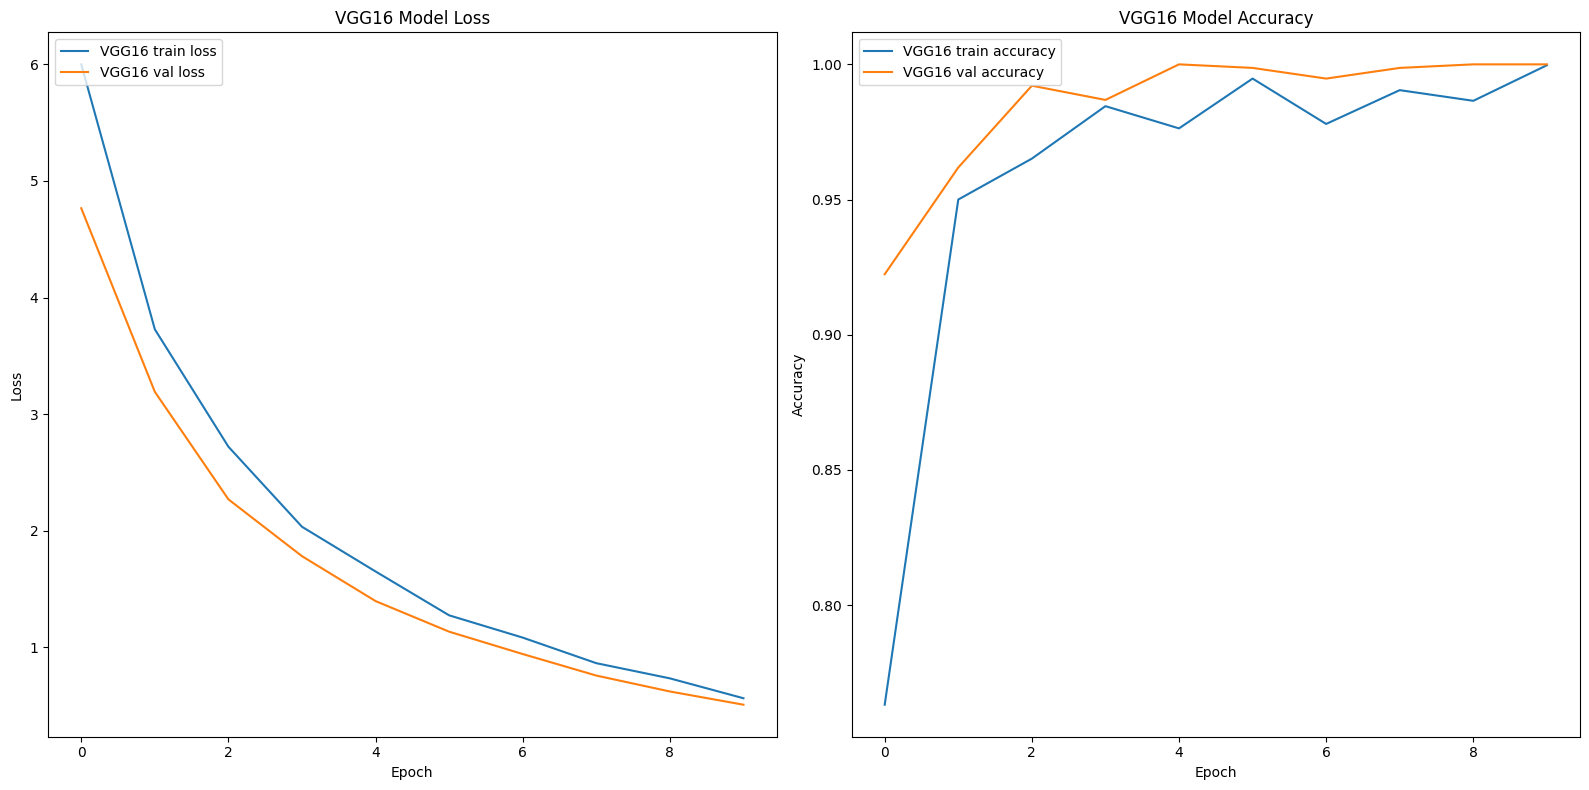

Training VGG19 model...
80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step
Epoch 1/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 1162s 6s/step - accuracy: 0.1682 - loss: 7.7220 - val_accuracy: 0.2908 - val_loss: 4.7500
Epoch 2/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 1114s 6s/step - accuracy: 0.3796 - loss: 3.9477 - val_accuracy: 0.6763 - val_loss: 2.2749
Epoch 3/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 1059s 6s/step - accuracy: 0.7302 - loss: 1.8815 - val_accuracy: 0.8645 - val_loss: 1.2102
Epoch 4/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 1020s 5s/step - accuracy: 0.7971 - loss: 1.1826 - val_accuracy: 0.8368 - val_loss: 0.8216
Epoch 5/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 1019s 5s/step - accuracy: 0.8672 - loss: 0.8160 - val_accuracy: 0.9395 - val_loss: 0.6263
Epoch 6/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 1025s 5s/step - accuracy: 0.9411 - loss: 0.6036 - val_accuracy: 0.9697 - val_loss: 0.4348
Epoch 7/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 1019s 5s/step - accuracy: 0.9583 - loss: 0.4520 - val_accuracy: 0.9737 - val_loss: 0.3759
Epoch 8/10
190

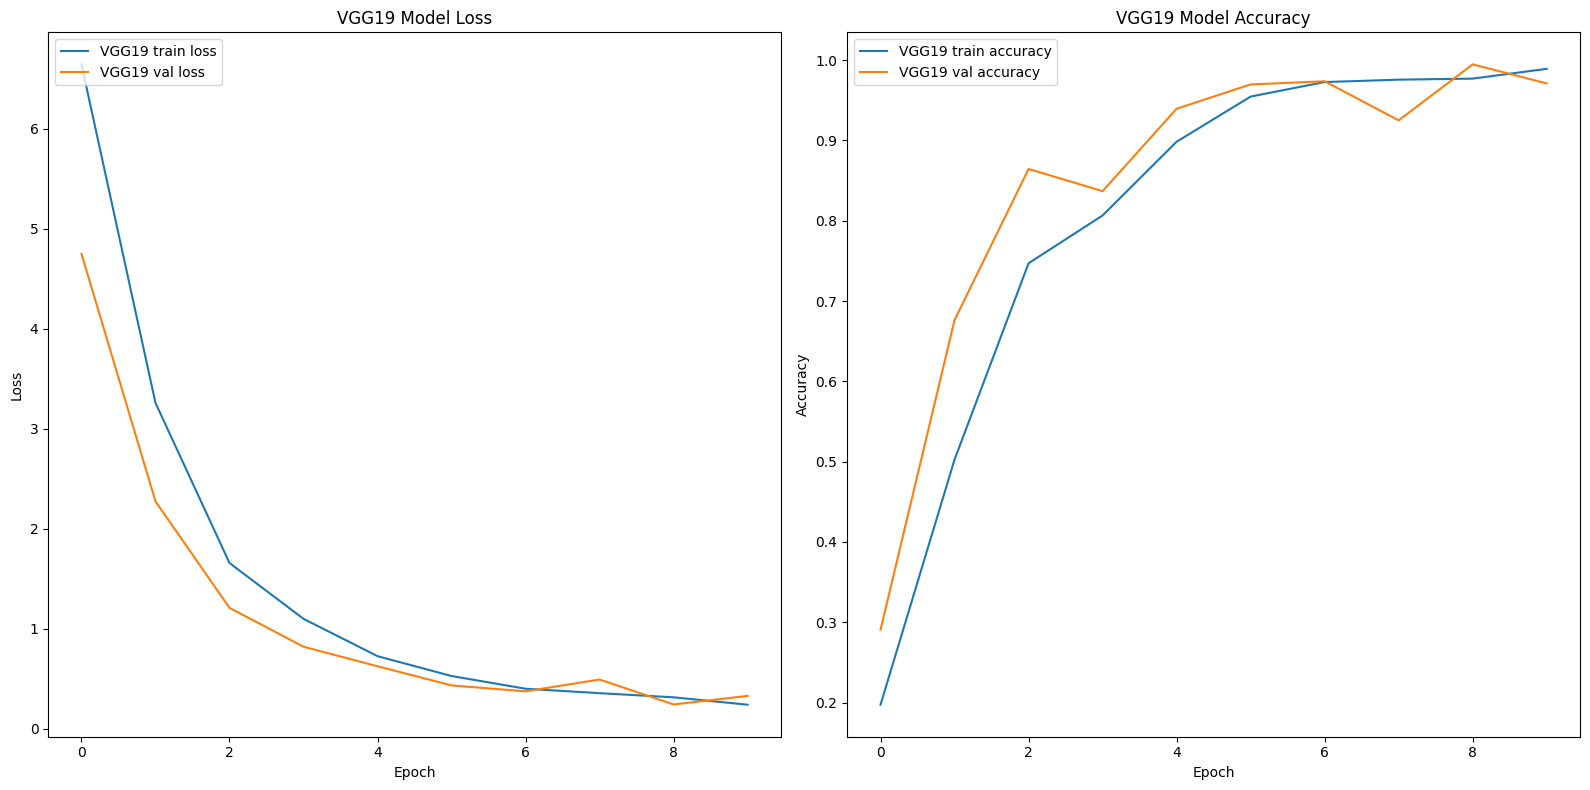

Training ResNet50 model...
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 387s 2s/step - accuracy: 0.8039 - loss: 13.3735 - val_accuracy: 0.1447 - val_loss: 12.0879
Epoch 2/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 364s 2s/step - accuracy: 0.9869 - loss: 9.0502 - val_accuracy: 0.2921 - val_loss: 8.7445
Epoch 3/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 363s 2s/step - accuracy: 0.9907 - loss: 5.9613 - val_accuracy: 0.3395 - val_loss: 6.0110
Epoch 4/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 364s 2s/step - accuracy: 0.9915 - loss: 3.8130 - val_accuracy: 0.6789 - val_loss: 3.7735
Epoch 5/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 366s 2s/step - accuracy: 0.9886 - loss: 2.4181 - val_accuracy: 0.7250 - val_loss: 2.8725
Epoch 6/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 364s 2s/step - accuracy: 0.9931 - loss: 1.5380 - val_accuracy: 0.9684 - val_loss: 1.1417
Epoch 7/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 364s 2s/step - accuracy: 0.9899 - loss: 0.9741 - val_accuracy: 0.9895 - val_loss: 0.6934
Epoch 8/10
190/19

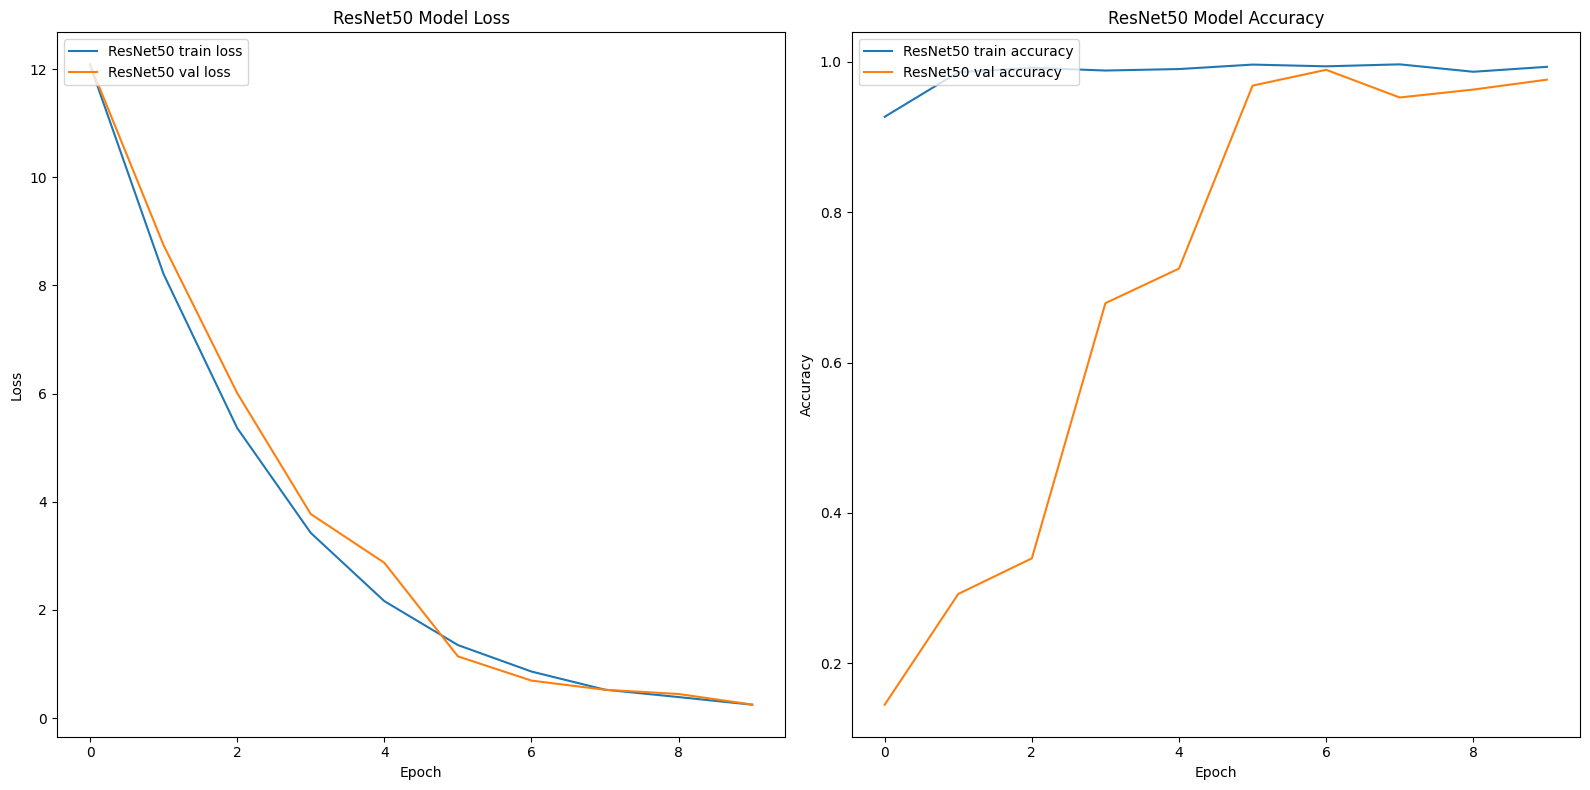

Training DenseNet121 model...
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 442s 2s/step - accuracy: 0.7042 - loss: 9.8315 - val_accuracy: 0.9816 - val_loss: 6.1465
Epoch 2/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 394s 2s/step - accuracy: 0.9884 - loss: 5.4823 - val_accuracy: 0.9803 - val_loss: 4.0290
Epoch 3/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 392s 2s/step - accuracy: 0.9915 - loss: 3.6822 - val_accuracy: 0.9961 - val_loss: 2.8519
Epoch 4/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 392s 2s/step - accuracy: 0.9910 - loss: 2.6762 - val_accuracy: 0.9961 - val_loss: 2.1327
Epoch 5/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 393s 2s/step - accuracy: 0.9944 - loss: 2.0064 - val_accuracy: 0.9974 - val_loss: 1.6031
Epoch 6/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 394s 2s/step - accuracy: 0.9974 - loss: 1.5037 - val_accuracy: 0.9974 - val_loss: 1.2018
Epoch 7/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 391s 2s/step - accuracy: 0.9982 - loss: 1.1209 - val_accuracy: 0.9934 - val_loss: 0.9122
Epoch 8/10
190/1

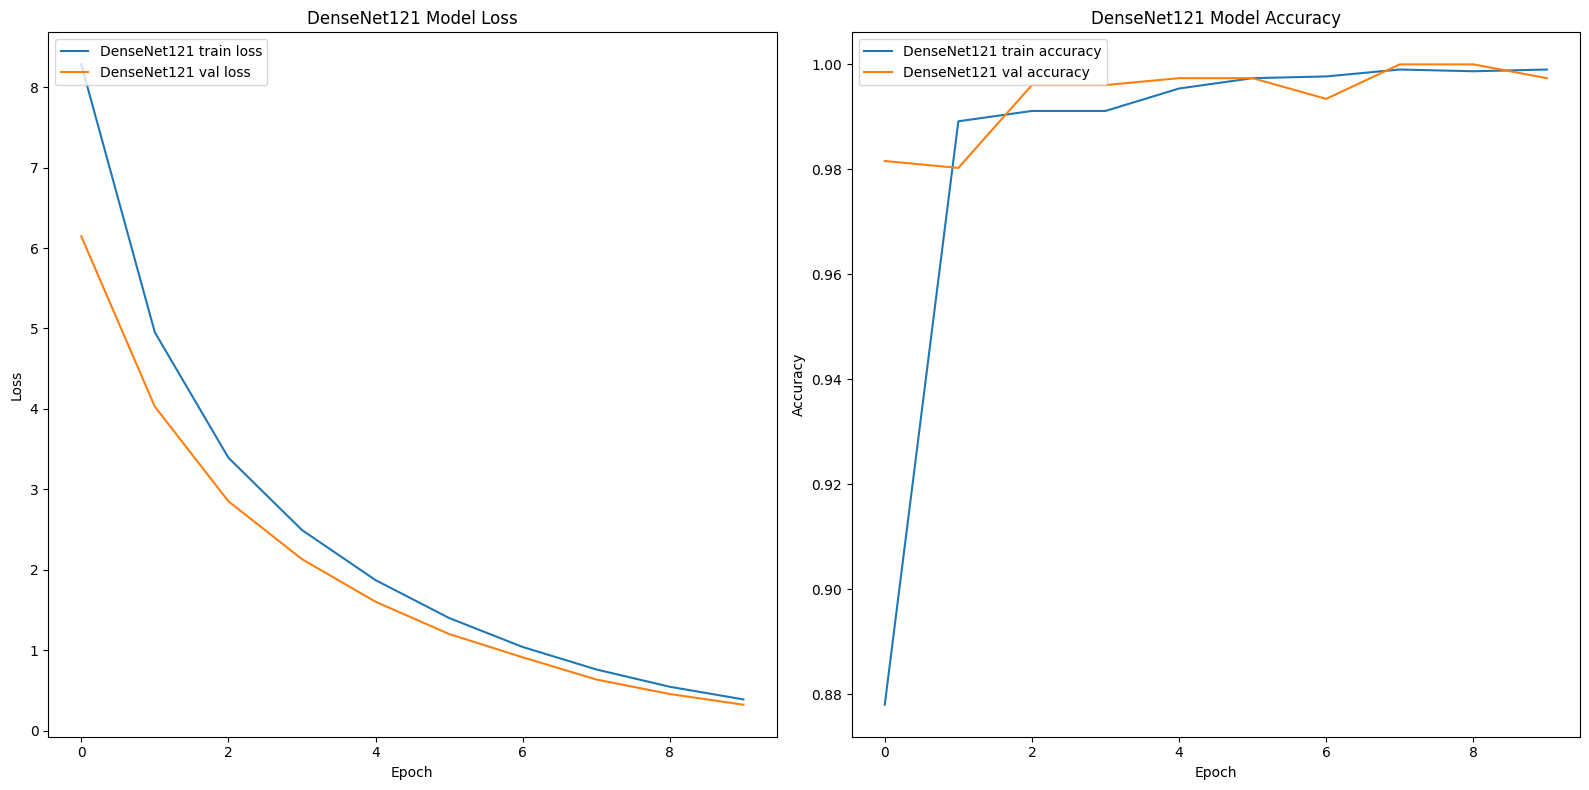

Training AlexNet model...


c:\Users\ADMIN\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 94s 487ms/step - accuracy: 0.1437 - loss: 63.7729 - val_accuracy: 0.2789 - val_loss: 10.9071
Epoch 2/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 92s 483ms/step - accuracy: 0.2818 - loss: 7.6254 - val_accuracy: 0.4724 - val_loss: 2.8490
Epoch 3/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 92s 485ms/step - accuracy: 0.5223 - loss: 2.4312 - val_accuracy: 0.6289 - val_loss: 1.5833
Epoch 4/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 92s 483ms/step - accuracy: 0.6640 - loss: 1.5025 - val_accuracy: 0.6961 - val_loss: 1.3060
Epoch 5/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 92s 485ms/step - accuracy: 0.7238 - loss: 1.1485 - val_accuracy: 0.7947 - val_loss: 1.0042
Epoch 6/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 92s 483ms/step - accuracy: 0.7851 - loss: 0.9823 - val_accuracy: 0.8158 - val_loss: 0.8052
Epoch 7/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 93s 490ms/step - accuracy: 0.8431 - loss: 0.7603 - val_accuracy: 0.8697 - val_loss: 0.7134
Epoch 8/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 92s 484ms/step - accuracy: 0.8609 - loss:

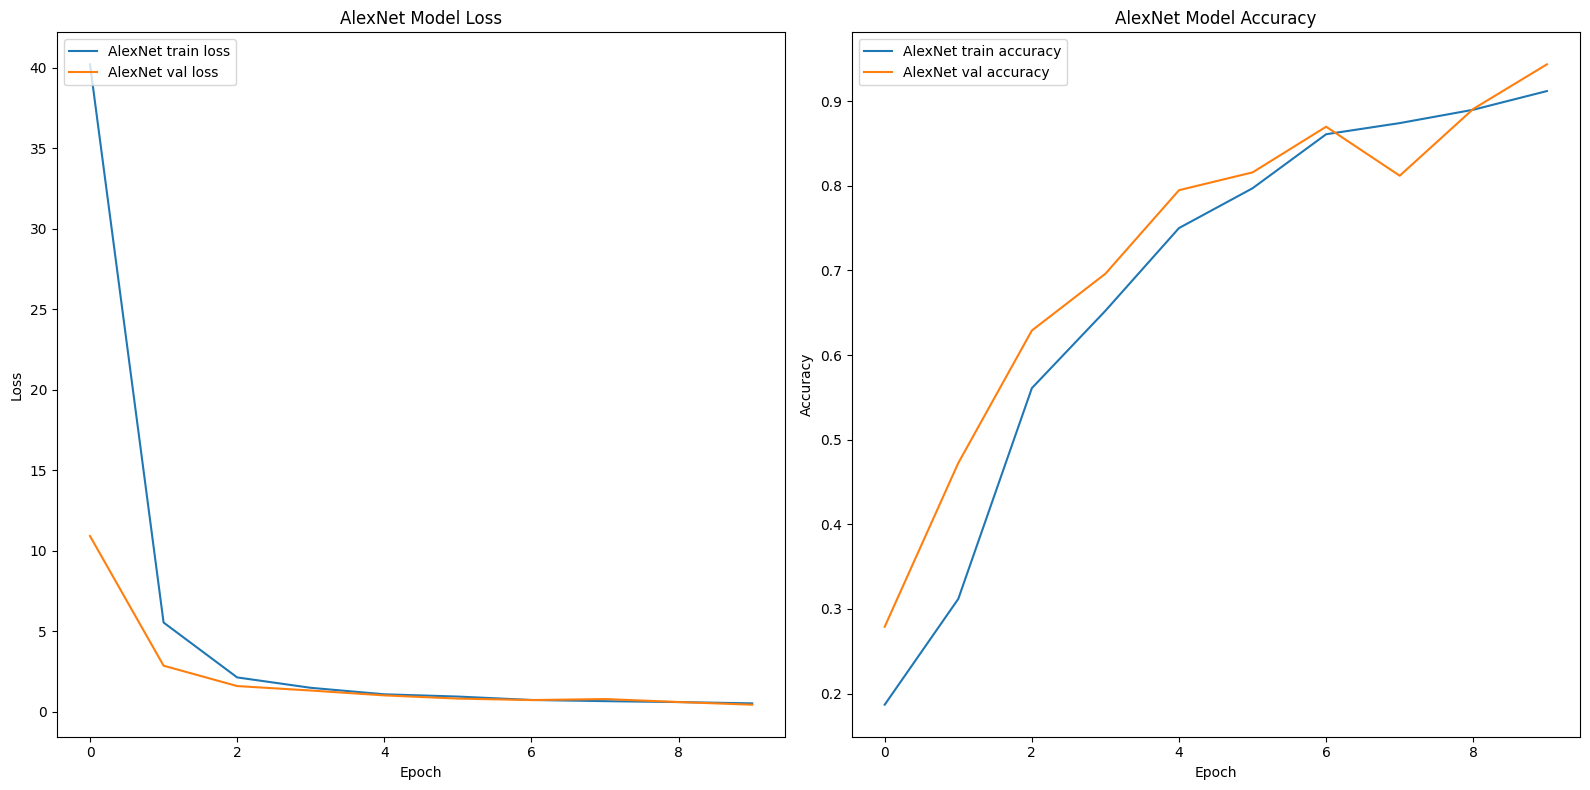

In [26]:
models = ['VGG16', 'VGG19', 'ResNet50', 'DenseNet121', 'AlexNet']
history_dict = {}
best_weights = {}

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

for model_name in models:
    print(f"Training {model_name} model...")
    model = build_model(model_name)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(
        x_train, y_train,
        batch_size=16,
        epochs=10,
        validation_data=(x_val, y_val),  # Validation data for validation split
        verbose=1
    )

    history_dict[model_name] = history.history
    best_weights[model_name] = model
    print(f"{model_name} model weights saved.")


    fig, ax = plt.subplots(1, 2, figsize=(16, 8))
    # Loss plot
    ax[0].plot(history.history['loss'], label=f'{model_name} train loss')
    ax[0].plot(history.history['val_loss'], label=f'{model_name} val loss')
    ax[0].set_title(f'{model_name} Model Loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(loc='upper left')
    # Accuracy plot
    ax[1].plot(history.history['accuracy'], label=f'{model_name} train accuracy')
    ax[1].plot(history.history['val_accuracy'], label=f'{model_name} val accuracy')
    ax[1].set_title(f'{model_name} Model Accuracy')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(loc='upper left')

    plt.tight_layout()
    plt.show()


In [20]:
from keras.models import load_model

vgg16_model = load_model('vgg16_best.h5')
vgg19_model = load_model('vgg19_best.h5')
resnet50_model = load_model('resnet50_best.h5')
densenet121_model = load_model('densenet121_best.h5')
alexnet_model = load_model('alexnet_best.h5')

best_weights = {
    'VGG16': vgg16_model,
    'VGG19': vgg19_model,
    'ResNet50': resnet50_model,
    'DenseNet121': densenet121_model,
    'AlexNet': alexnet_model
}


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'vgg16_best.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Đảm bảo các biến sau đã tồn tại trong notebook: 
# models, best_weights, x_test, y_test, classes

for model_name in models:
    print(f"Evaluating {model_name} model on test data...")
    model = best_weights[model_name]

    scores = model.evaluate(x_test, y_test, verbose=0)
    print(f"{model_name} Test Accuracy: {scores[1] * 100:.2f}%")

    y_pred = np.argmax(model.predict(x_test), axis=1)
    y_true = np.argmax(y_test, axis=1)

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()

    print(classification_report(y_true, y_pred, target_names=classes))


Evaluating VGG16 model on test data...


NameError: name 'best_weights' is not defined